# Step 1 — Data Prep (BankChurners)

**Purpose.** Turn the raw BankChurners CSV into a clean, analysis-ready table with a clear **churn** target and a few **engineered features** that make business sense.

**You’ll see:**
1) What we loaded and why the schema matters  
2) How we define the **churn label** (1 = attrited, 0 = existing)  
3) Simple data quality checks (missing values, types)  
4) Practical engineered features (usage rate, inactivity flags, utilization bands)  
5) Quick visuals to explain *why* these features help detect churn  
6) Save a processed CSV for modeling & Tableau


In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RAW = Path("../data/raw")
PROC = Path("../data/processed"); PROC.mkdir(parents=True, exist_ok=True)

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


## Load the raw data

We load **BankChurners** from `../data/raw/`.  
Why the flexibility? Kaggle forks sometimes change filenames. We also normalize column names to `snake_case` so code is stable.


In [15]:
candidates = list(RAW.glob("BankChurners*.csv")) + list(RAW.glob("*Churn*.csv")) + list(RAW.glob("*.csv"))
assert candidates, "No CSV found in ../data/raw. Place your BankChurners CSV there."

df = pd.read_csv(candidates[0], encoding="utf-8-sig")

def to_snake(s: str) -> str:
    return (s.strip().replace(" ", "_").replace("-", "_").replace("/", "_").lower())

df.columns = [to_snake(c) for c in df.columns]

print("Loaded:", candidates[0].name, "→ shape:", df.shape)
df.head(29)


Loaded: BankChurners.csv → shape: (10127, 23)


,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,"12,691.000",777,"11,914.000",1.335,1144,42,1.625,0.061,0.000,1.000
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,"8,256.000",864,"7,392.000",1.541,1291,33,3.714,0.105,0.000,1.000
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,"3,418.000",0,"3,418.000",2.594,1887,20,2.333,0.000,0.000,1.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,"3,313.000",2517,796.000,1.405,1171,20,2.333,0.760,0.000,1.000
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,"4,716.000",0,"4,716.000",2.175,816,28,2.500,0.000,0.000,1.000
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,"4,010.000",1247,"2,763.000",1.376,1088,24,0.846,0.311,0.000,1.000
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,"34,516.000",2264,"32,252.000",1.975,1330,31,0.722,0.066,0.000,1.000
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,"29,081.000",1396,"27,685.000",2.204,1538,36,0.714,0.048,0.000,1.000
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,"22,352.000",2517,"19,835.000",3.355,1350,24,1.182,0.113,0.000,1.000
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,"11,656.000",1677,"9,979.000",1.524,1441,32,0.882,0.144,0.000,1.000


## Target definition: `churn`

The dataset provides `Attrition_Flag` (e.g., “Attrited Customer”, “Existing Customer”).  
We convert it to **`churn`**:  
- `1` = Attrited Customer (closed/left)  
- `0` = Existing Customer (retained)

This binary label is what I’ll model later.

Churn rate: 16.066%


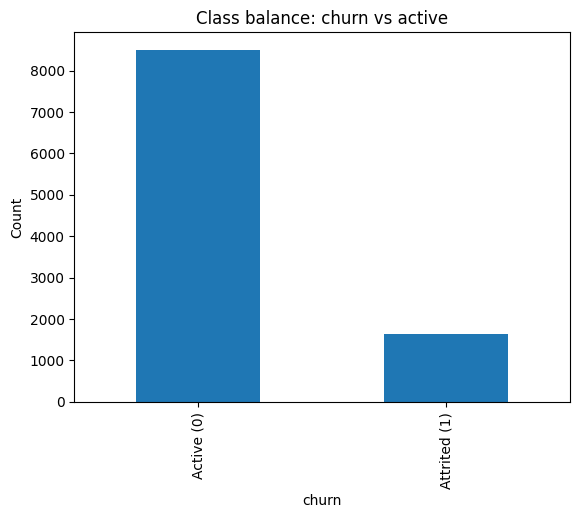

In [10]:
# Preserve a stable ID (CLIENTNUM) for joining/visuals
if "clientnum" in df.columns:
    df = df.rename(columns={"clientnum": "id"})
else:
    df["id"] = np.arange(len(df))

# Create binary target
if "attrition_flag" in df.columns:
    df["churn"] = df["attrition_flag"].str.contains("attrited", case=False, na=False).astype(int)
elif "exited" in df.columns:
    df["churn"] = df["exited"].astype(int)
else:
    raise ValueError("Expected 'Attrition_Flag' or 'Exited' column for a churn label.")

# Show class balance
rate = df["churn"].mean()
print(f"Churn rate: {rate:.3%}")
vc = df["churn"].value_counts().rename({0: "Active (0)", 1: "Attrited (1)"})
ax = vc.plot(kind="bar")
ax.set_title("Class balance: churn vs active")
ax.set_ylabel("Count")
plt.show()


## Data quality checks

We check:
- **Types** (numeric vs categorical) — needed for encoding/scaling later  
- **Missing values** — decide fill/drop strategies  
- **Identifiers** — drop noisy IDs (keep `id`)


In [11]:
# Drop obvious identifiers that don't help modeling (keep 'id')
drop_cols = [c for c in ["rownumber","customerid","surname"] if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")

# Categorical columns (present in BankChurners)
cat_cols = [c for c in [
    "gender","education_level","marital_status","income_category","card_category","attrition_flag"
] if c in df.columns]

# Numeric columns we expect
num_cols = [c for c in [
    "customer_age","dependent_count","months_on_book","total_relationship_count",
    "months_inactive_12_mon","contacts_count_12_mon","credit_limit","total_revolving_bal",
    "avg_open_to_buy","total_amt_chng_q4_q1","total_trans_amt","total_trans_ct",
    "total_ct_chng_q4_q1","avg_utilization_ratio"
] if c in df.columns]

# Cast
for c in cat_cols:
    df[c] = df[c].astype("string").str.strip()

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Missingness summary
miss = df.isna().mean().sort_values(ascending=False).head(10)
print("Top missingness:")
display(miss.to_frame("missing_frac").T)


Top missingness:


,id,attrition_flag,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,avg_utilization_ratio,total_ct_chng_q4_q1,total_trans_ct,total_trans_amt,total_amt_chng_q4_q1,avg_open_to_buy
missing_frac,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Engineered features — Why these?

- **`avg_trans_amt`** = `total_trans_amt / total_trans_ct` → proxy for ticket size; churners may have lower, sporadic spend.  
- **`trans_per_month`** = `total_trans_ct / 12` → cadence/engagement.  
- **`contact_rate_12m`** = `contacts_count_12_mon / 12` → more contacts can signal issues or proactive outreach.  
- **`inactive_3plus_12m`**: flag if `months_inactive_12_mon ≥ 3` → sustained inactivity is a risk signal.  
- **`util_band`**: binned `avg_utilization_ratio` → interpretable credit use levels (very_low…very_high).


In [16]:
df_eng = df.copy()

if {"total_trans_amt","total_trans_ct"}.issubset(df_eng.columns):
    df_eng["avg_trans_amt"] = df_eng["total_trans_amt"] / df_eng["total_trans_ct"].replace(0, np.nan)
    df_eng["avg_trans_amt"] = df_eng["avg_trans_amt"].fillna(0)

if "total_trans_ct" in df_eng.columns:
    df_eng["trans_per_month"] = df_eng["total_trans_ct"] / 12.0

if "contacts_count_12_mon" in df_eng.columns:
    df_eng["contact_rate_12m"] = df_eng["contacts_count_12_mon"] / 12.0

if "months_inactive_12_mon" in df_eng.columns:
    df_eng["inactive_3plus_12m"] = (df_eng["months_inactive_12_mon"] >= 3).astype(int)

if "avg_utilization_ratio" in df_eng.columns:
    df_eng["util_band"] = pd.cut(
        df_eng["avg_utilization_ratio"],
        bins=[-0.001, 0.1, 0.3, 0.6, 0.9, 1.0],
        labels=["very_low","low","medium","high","very_high"]
    ).astype("string")

keep = [c for c in [
    "id","churn",
    "customer_age","gender","dependent_count","education_level","marital_status","income_category","card_category",
    "months_on_book","total_relationship_count","months_inactive_12_mon","contacts_count_12_mon",
    "credit_limit","total_revolving_bal","avg_open_to_buy",
    "total_amt_chng_q4_q1","total_trans_amt","total_trans_ct","total_ct_chng_q4_q1","avg_utilization_ratio",
    "avg_trans_amt","trans_per_month","contact_rate_12m","inactive_3plus_12m","util_band"
] if c in df_eng.columns]

df_proc = df_eng[keep].copy()
df_proc.head(17)


,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,avg_trans_amt,trans_per_month,contact_rate_12m,inactive_3plus_12m,util_band
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,...,1.335,1144,42,1.625,0.061,27.238,3.500,0.250,0,very_low
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,...,1.541,1291,33,3.714,0.105,39.121,2.750,0.167,0,low
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,...,2.594,1887,20,2.333,0.000,94.350,1.667,0.000,0,very_low
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,...,1.405,1171,20,2.333,0.760,58.550,1.667,0.083,1,high
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,...,2.175,816,28,2.500,0.000,29.143,2.333,0.000,0,very_low
5,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,...,1.376,1088,24,0.846,0.311,45.333,2.000,0.167,0,medium
6,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,...,1.975,1330,31,0.722,0.066,42.903,2.583,0.250,0,very_low
7,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,...,2.204,1538,36,0.714,0.048,42.722,3.000,0.167,0,very_low
8,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,...,3.355,1350,24,1.182,0.113,56.250,2.000,0.000,0,low
9,48,M,2,Graduate,Single,$80K - $120K,Blue,36,6,3,...,1.524,1441,32,0.882,0.144,45.031,2.667,0.250,1,low


## Quick visuals — What patterns look predictive?

We plot a few **intuitive** relationships. These don’t prove causality; they explain *why a model might learn signal*.

- **Inactivity vs churn**: churners should skew to higher inactivity months  
- **Engagement (transactions) vs churn**: frequent users churn less  
- **Utilization vs churn**: extreme utilization can correlate with risk or disengagement


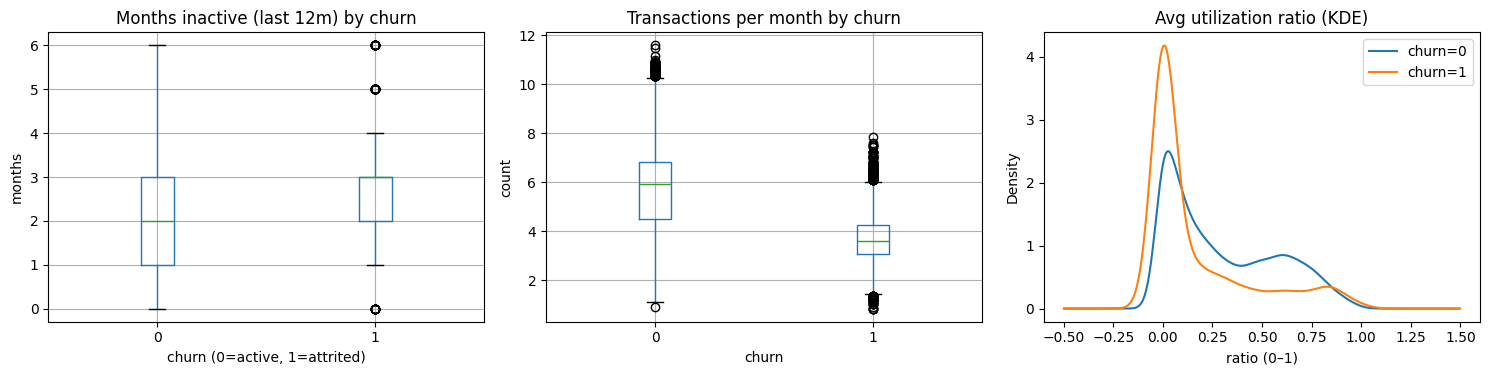

In [13]:
# 1) Inactivity months by churn
fig, ax = plt.subplots(1, 3, figsize=(15,4))

if "months_inactive_12_mon" in df_proc.columns:
    df_proc.boxplot(column="months_inactive_12_mon", by="churn", ax=ax[0])
    ax[0].set_title("Months inactive (last 12m) by churn")
    ax[0].set_xlabel("churn (0=active, 1=attrited)")
    ax[0].set_ylabel("months")

# 2) Transactions per month by churn
if "trans_per_month" in df_proc.columns:
    df_proc.boxplot(column="trans_per_month", by="churn", ax=ax[1])
    ax[1].set_title("Transactions per month by churn")
    ax[1].set_xlabel("churn")
    ax[1].set_ylabel("count")

# 3) Utilization ratio distribution by churn
if "avg_utilization_ratio" in df_proc.columns:
    for label, grp in df_proc.groupby("churn"):
        grp["avg_utilization_ratio"].plot(kind="kde", ax=ax[2], label=f"churn={label}")
    ax[2].set_title("Avg utilization ratio (KDE)")
    ax[2].set_xlabel("ratio (0–1)")
    ax[2].legend()

plt.suptitle("")
plt.tight_layout()
plt.show()


## Save processed data

We persist a clean CSV for modeling (Step 2) and visualization (Tableau later).  
The raw file remains in `data/raw/` and is ignored by Git; the processed file is small and reproducible.


In [14]:
out_path = PROC / "bankchurners_processed.csv"
df_proc.to_csv(out_path, index=False)
print("Saved:", out_path.as_posix(), "→ shape:", df_proc.shape)
print("Churn rate:", df_proc["churn"].mean().round(3))


Saved: ../data/processed/bankchurners_processed.csv → shape: (10127, 26)
Churn rate: 0.161


### Next (Step 2): Split & Preprocess

- **Stratified train/test split** to preserve churn balance  
- **Preprocessing pipeline**: One-Hot Encode categoricals + Standardize numerics  
- **Leakage guardrails**: no features created from future outcomes

Then we’ll move to **Step 3: Modeling** (logistic baseline → gradient boosting + calibration) and **Step 4: ROI** (targeting curve + sensitivity).
